# 📊 Мини-проект: Анализ заказов с помощью SQLite и Pandas

In [1]:

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display


## Создание базы данных и таблицы

In [2]:

conn = sqlite3.connect(':memory:')
cursor = conn.cursor()


In [3]:
# Создаем таблицу orders
cursor.execute('''
CREATE TABLE orders (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id INTEGER,
    item TEXT,
    quantity INTEGER,
    price REAL,
    order_date TEXT
)
''')

In [4]:
cursor.execute('''
CREATE TABLE users (
    user_id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_name TEXT,
    registration_date TEXT
)
''')

In [5]:
# Проверим, созданы ли таблицы
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(tables)  # Выведет список всех таблиц в базе данных

[('orders',), ('sqlite_sequence',), ('users',)]


## Генерация фиктивных данных и вставка в таблицу

In [6]:
# Добавление пользователей
cursor.executemany('''
INSERT INTO users (user_name, registration_date)
VALUES (?, ?)
''', [
    ('John Doe', '2023-01-15'),
    ('Jane Smith', '2023-02-01')
])

# Добавление заказов
cursor.executemany('''
INSERT INTO orders (user_id, item, quantity, price, order_date)
VALUES (?, ?, ?, ?, ?)
''', [
    (1, 'Book', 2, 20.5, '2023-02-01'),
    (2, 'Laptop', 1, 500.0, '2023-02-05'),
    (1, 'Pen', 5, 1.5, '2023-02-07')
])

conn.commit()


In [7]:
# Получаем информацию о заказах с именем пользователя
cursor.execute('''
SELECT u.user_name, o.item, o.quantity, o.price, o.order_date
FROM users u
JOIN orders o ON u.user_id = o.user_id
''')

# Выводим результаты
for row in cursor.fetchall():
    print(row)

('John Doe', 'Book', 2, 20.5, '2023-02-01')
('Jane Smith', 'Laptop', 1, 500.0, '2023-02-05')
('John Doe', 'Pen', 5, 1.5, '2023-02-07')


## Выполнение SQL-запросов

In [8]:

queries = {
    "Общее количество заказов": "SELECT COUNT(*) FROM orders",
    "Общий доход": "SELECT ROUND(SUM(quantity * price), 2) AS revenue FROM orders",
    "Средний чек": "SELECT ROUND(AVG(quantity * price), 2) AS avg_order FROM orders",
    "Самый популярный товар": "SELECT item, COUNT(*) AS freq FROM orders GROUP BY item ORDER BY freq DESC LIMIT 1",
    "Доход по дням": '''
        SELECT order_date, ROUND(SUM(quantity * price), 2) as daily_revenue 
        FROM orders GROUP BY order_date ORDER BY order_date
    '''
}

results = {}
for title, q in queries.items():
    results[title] = pd.read_sql_query(q, conn)
    print(f"--- {title} ---")
    display(results[title])


--- Общее количество заказов ---


,COUNT(*)
0,3


--- Общий доход ---


,revenue
0,548.5


--- Средний чек ---


,avg_order
0,182.83


--- Самый популярный товар ---


,item,freq
0,Pen,1


--- Доход по дням ---


,order_date,daily_revenue
0,2023-02-01,41.0
1,2023-02-05,500.0
2,2023-02-07,7.5


In [9]:
#Подсчитаем выручку по пользователям, но только для пользователей с более чем 5 заказами
cursor.execute('''
SELECT user_name, total_revenue 
FROM (
    SELECT u.user_name, SUM(o.price * o.quantity) AS total_revenue
    FROM users u
    LEFT JOIN orders o ON u.user_id = o.user_id
    GROUP BY u.user_name
    HAVING COUNT(o.id) > 5
) AS revenue;
''')

In [10]:
#Пример запроса для анализа дохода по дням:
cursor.execute('''
SELECT order_date, ROUND(SUM(price * quantity), 2) AS daily_revenue
FROM orders
GROUP BY order_date
ORDER BY order_date;
''')

In [11]:
cursor.execute('''
SELECT * FROM orders
LIMIT 10 OFFSET 20;
''')

## Визуализация данных по выручке

In [12]:
# Загрузка данных из базы данных
daily_revenue = pd.read_sql_query('''
    SELECT order_date, ROUND(SUM(price * quantity), 2) AS daily_revenue
    FROM orders
    GROUP BY order_date
    ORDER BY order_date;
''', conn)

In [13]:
# Преобразуем колонку с датой в формат datetime
daily_revenue['order_date'] = pd.to_datetime(daily_revenue['order_date'])

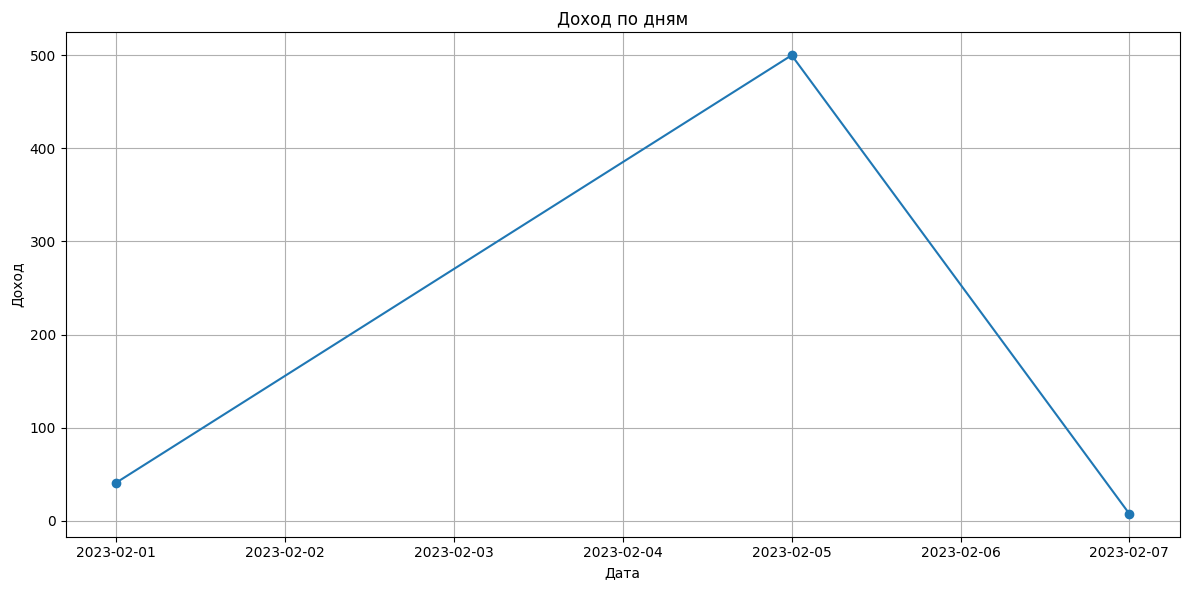

In [14]:
# Визуализация данных
plt.figure(figsize=(12, 6))
plt.plot(daily_revenue['order_date'], daily_revenue['daily_revenue'], marker='o')
plt.title('Доход по дням')
plt.xlabel('Дата')
plt.ylabel('Доход')
plt.grid(True)
plt.tight_layout()
plt.show()

## Закрытие соединения с БД

In [15]:
conn.close()